# **Heart Disease Diagnostic Tool**

## **Introduction:**

Cardiovascular diseases are the leading cause of death globally, estimated to take around 17.9 million lives each year. It is a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions (WHO, n.d.). For our project, the question we are trying to answer is:

“Can we use patient attributes from a clinic's database to predict whether a patient has heart disease?”

The data set used to answer this questions was built using 303 patient information from Cleveland and was processed to include 14 out of 76 attributes most commonly used by published experiments. It was obtained from https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data.




### **Preliminary exploratory data analysis:**

In [1]:
library(rvest)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fi

#### **Reading and Wrangling the Data**

In [2]:
set.seed(293)

dataset_test <- download.file(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
    "heart_disease.csv")

heart_data <- read_csv("heart_disease.csv", col_names = FALSE)


heart_data <- rename(heart_data, 
                     age =X1, #represented in years - numerical
                     sex =X2, #1 representing male; 0 representing female - categorical
                     cp =X3, #Chest pain type - categorical 
                     trestbps =X4, #resting blood pressure (mmHg) - numerical
                     chol = X5, #serum cholesterol (mg/dl) - numerical
                     fbs =X6, #fasting blood sugar > 120 mg/dl (1 = true; 0 = false) - categorical
                     restecg=X7, #resulting electrocardiographic results - categorical
                     thalach=X8, #maximum heart rate achieved - numerical
                     exang=X9, #exercise induced angina - categorical
                     oldpeak=X10, #slope of peak exercise ST segment - categorical
                     slope=X11, #slope of peak exercise ST segment - categorical
                     ca=X12, #number of major vessels - categorical
                     thal=X13, #thalassemia Severity - categorical
                     diagnosis=X14) #diagnosis of heart disease - categorical

idx <- heart_data == "?"
is.na(heart_data) <- idx                                 #eliminates ? and replaces with NA

heart_data[] <- sapply(heart_data, as.numeric) #converts all the data to numeric

names = c('sex', 'cp', 'exang', 'slope', 'thal', 'diagnosis', "restecg", "ca", "fbs")
heart_data[,names] <- lapply(heart_data[,names] , factor)

heart_data <- mutate(heart_data, diagnosis = ifelse(diagnosis == "1"|diagnosis == "2"|diagnosis == "3"|diagnosis == "4", "Positive", "Negative"))
heart_data <- mutate(heart_data, diagnosis = as.factor(diagnosis))          #changes the diagnosis values to strings

heart_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,Negative
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Positive
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Positive
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,Positive
57,0,2,130,236,0,2,174,0,0.0,2,1,3,Positive
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,Negative


# **Methods**

#### **Splitting data into training and testing sets**

In [3]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)          #splits data
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

We will be using K-nearest neighbours to solve our classification question, so we must split our data into a training set and a testing set. Training set will be used for building the classifier while the testing set will be used for evaluating accuracy of the classifier. 

Later on we will perform a 5-fold cross-validation to select the number of neighbours that gives the highest accuracy for our classifier.

#### **Number of Positive and Negative diagnoses**

In [4]:
count_train_summary <- group_by(heart_train, diagnosis) |>
    summarize(count=n())
count_train_summary

diagnosis,count
<fct>,<int>
Negative,123
Positive,104


From the training dataset we can see there's a good representation of patients with and without heart disease which is good, as later on we will know if our diagnosis tool is actually making accurate predictions instead of always predicting postive/negative.

#### **Number of missing values in each column**

In [5]:
heart_data |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    summarise_all(funs(sum(is.na(.))))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


age,trestbps,chol,thalach,oldpeak,diagnosis
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


We decided to avoid using categorical variables as our predictors because our goal is to perform classification using K-nearest neighbors, which would work better with numerical predictors.

All variables of interest have no missing values.

#### **Average of numerical columns**

In [6]:
stats_avg <- heart_train |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    group_by(diagnosis) |>
    summarize(across(age:oldpeak, mean, na.rm = TRUE))

stats_avg

diagnosis,age,trestbps,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,51.82114,128.3008,237.8862,158.9675,0.5699187
Positive,56.58654,132.1442,250.1635,139.1250,1.5788462


We then created this table to compare the average values of numerical attributes for positive and negative diagnoses. We see that age, chol, thalach, and oldpeak have the most significant difference between positive and negative diagnoses so we will perform visualization to choose two variables out of them to use in our model.

#### **Visualizations of Predictor Variables**


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



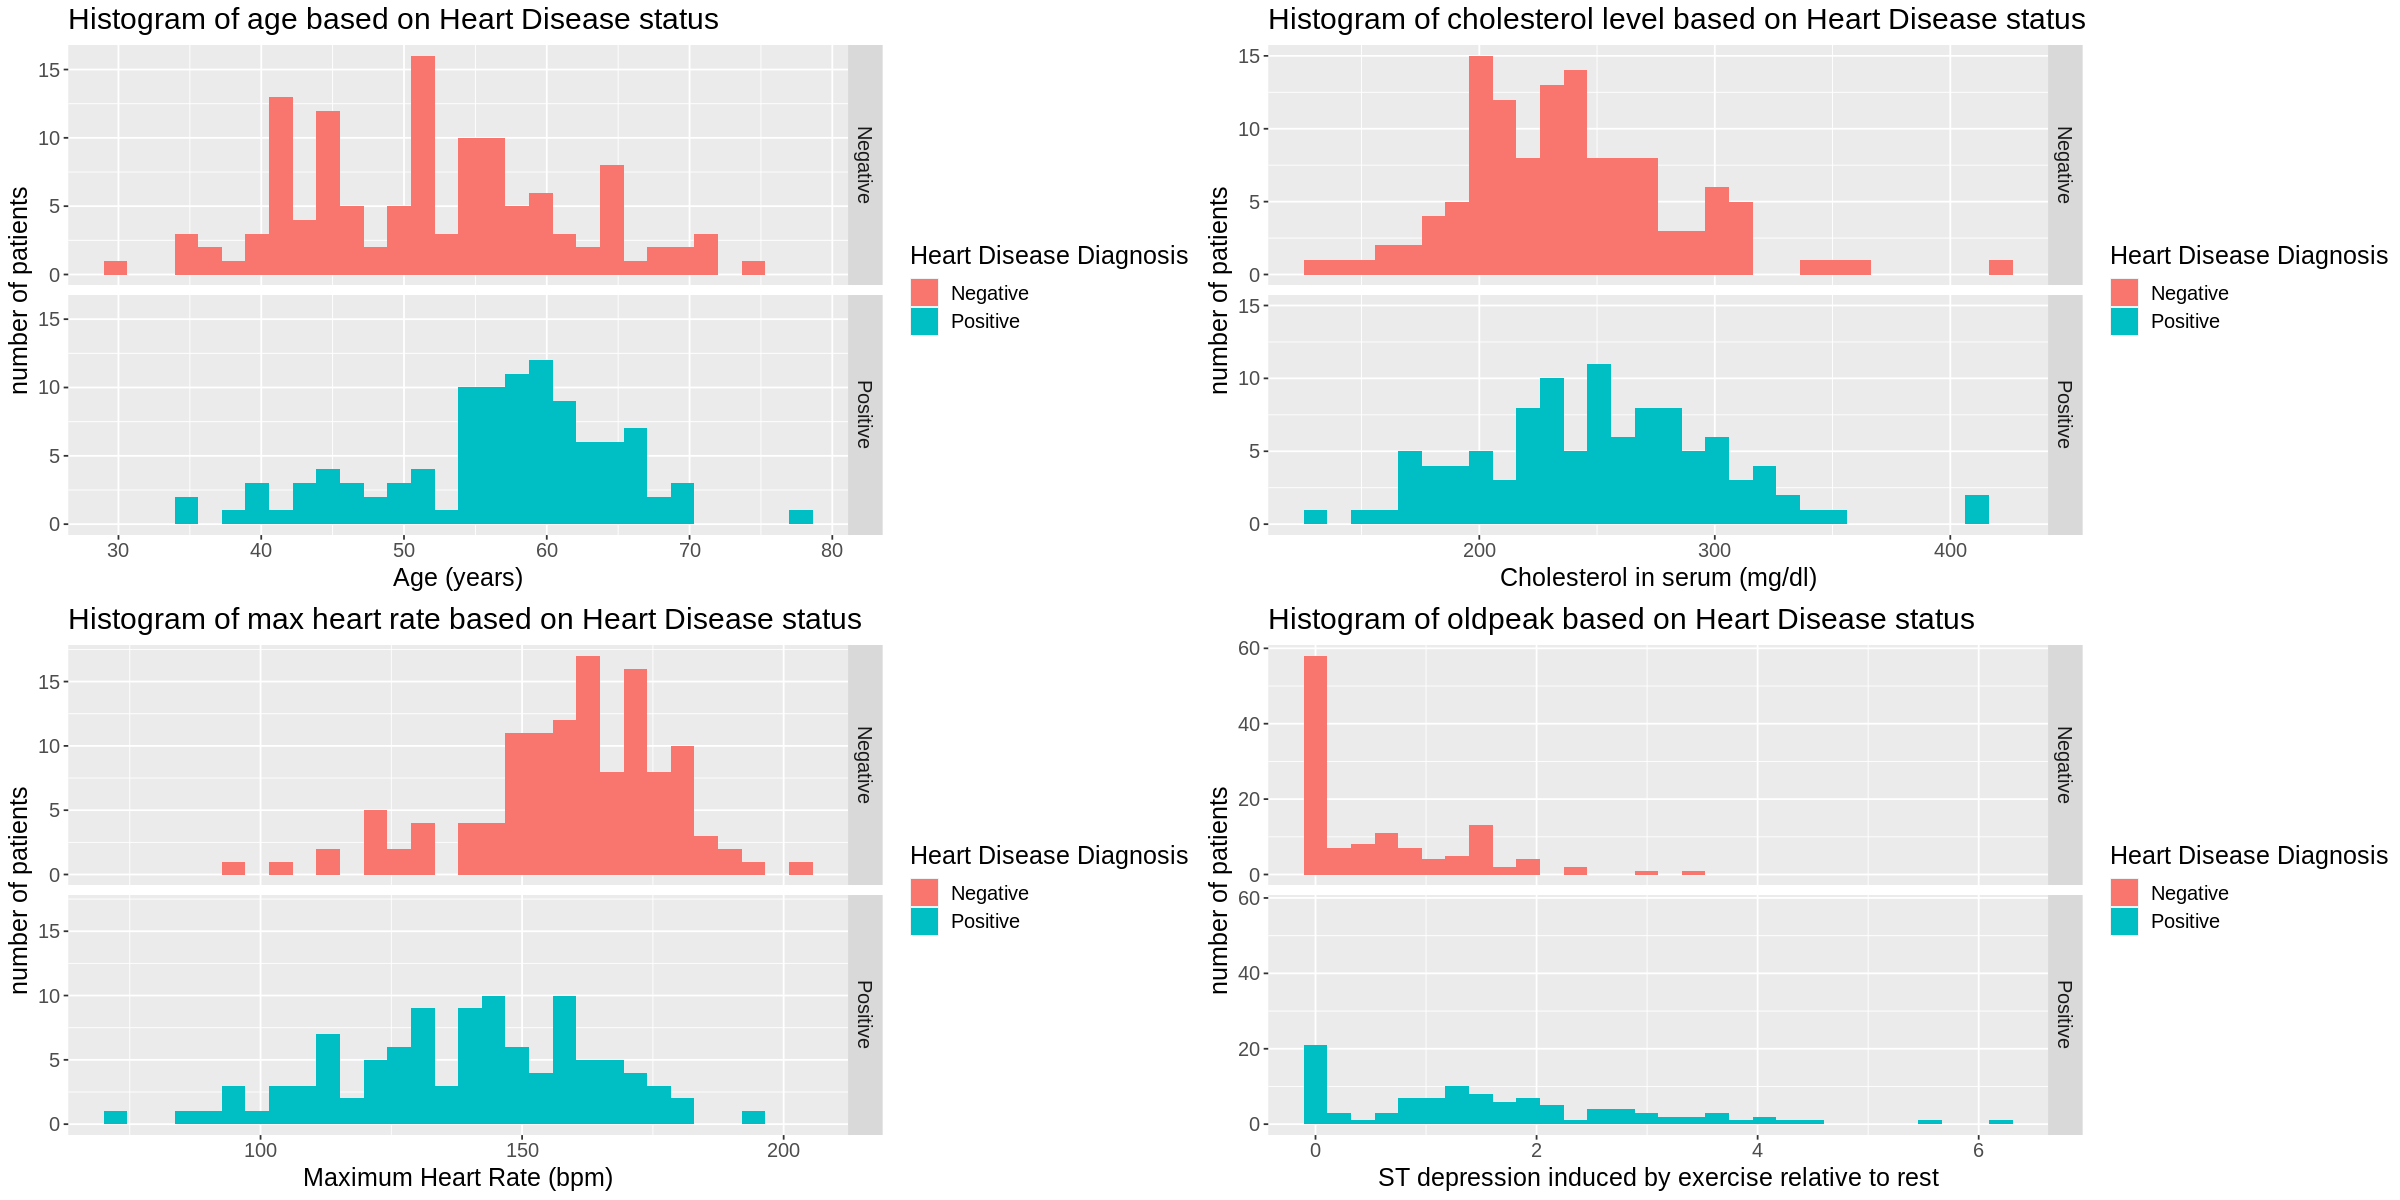

In [7]:
options(repr.plot.height = 10, repr.plot.width = 20)
library(gridExtra)

age_plot <- heart_train |>
        ggplot(aes(x = age, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Age (years)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of age based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))

chol_plot <- heart_train |>
        ggplot(aes(x = chol, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Cholesterol in serum (mg/dl)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of cholesterol level based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


thalach_plot <- heart_train |>
        ggplot(aes(x = thalach, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Maximum Heart Rate (bpm)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of max heart rate based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


oldpeak_plot <- heart_train |>
        ggplot(aes(x = oldpeak, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "ST depression induced by exercise relative to rest", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of oldpeak based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


grid.arrange(age_plot, chol_plot, thalach_plot, oldpeak_plot, ncol = 2)

These histograms show the number of patients that have negative and positive diagnosis for the four variables we are exploring.

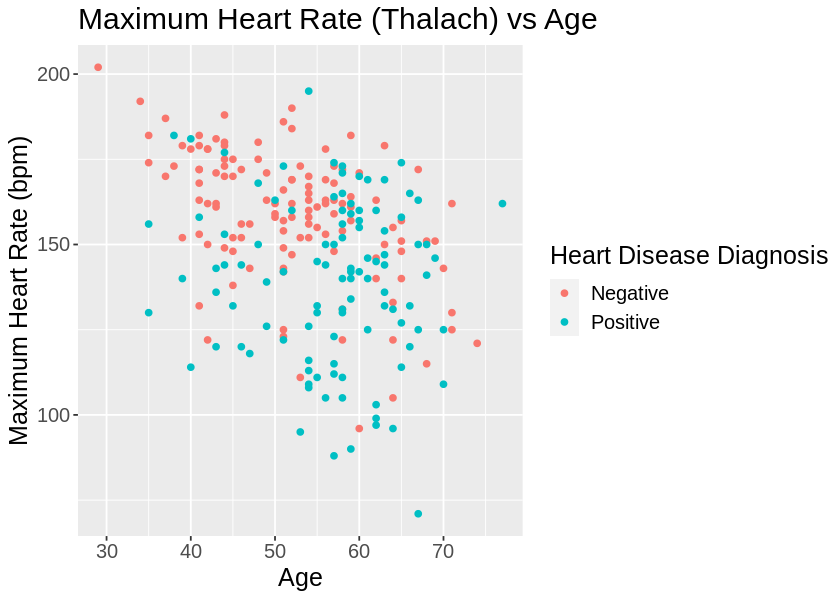

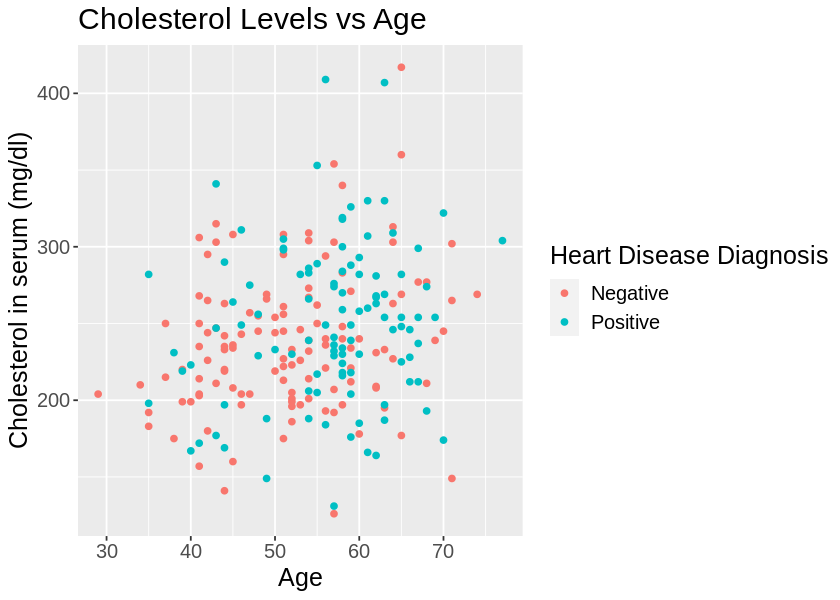

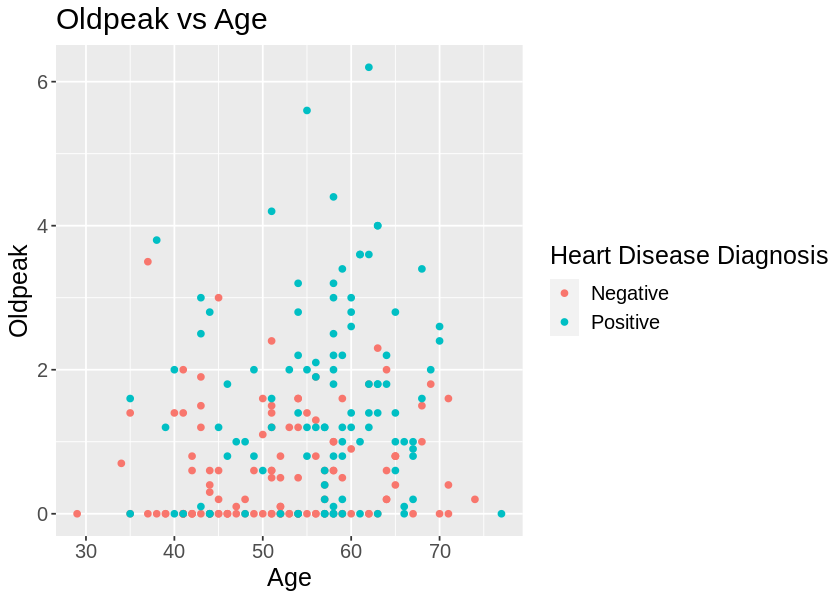

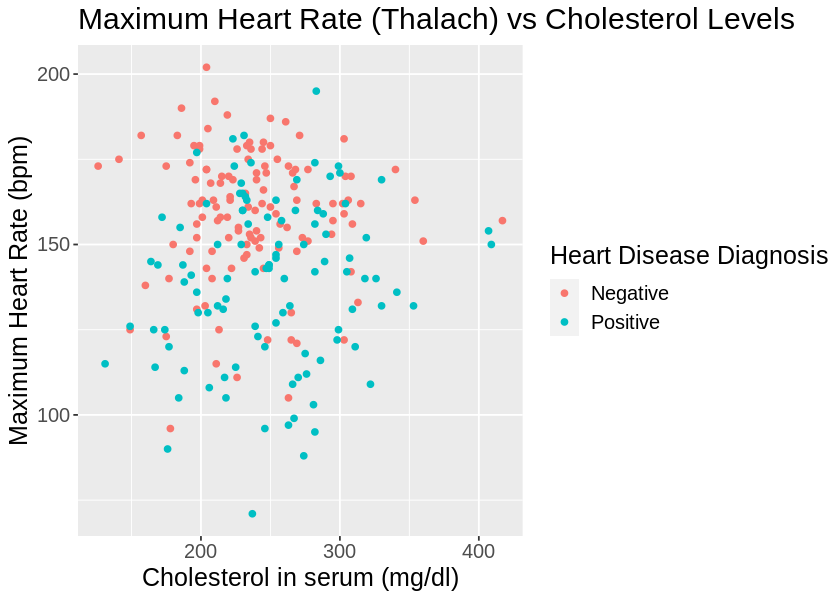

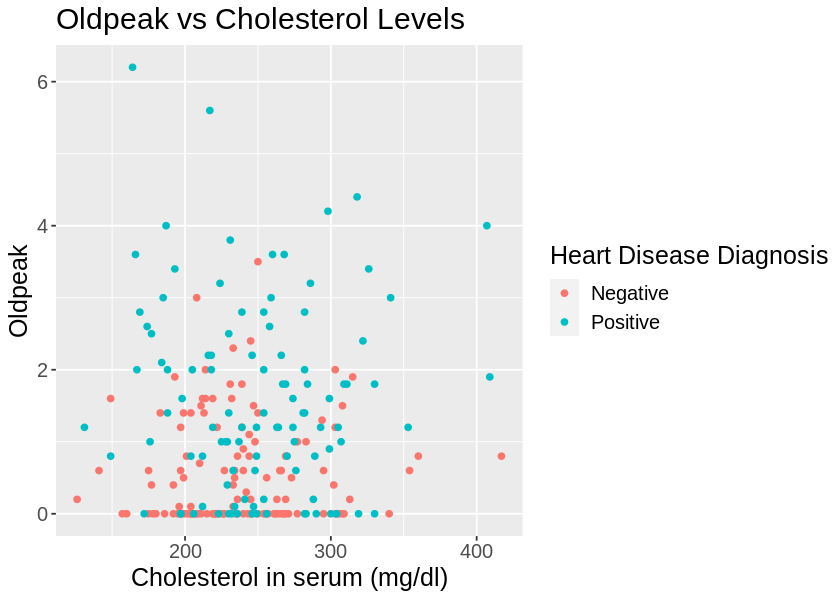

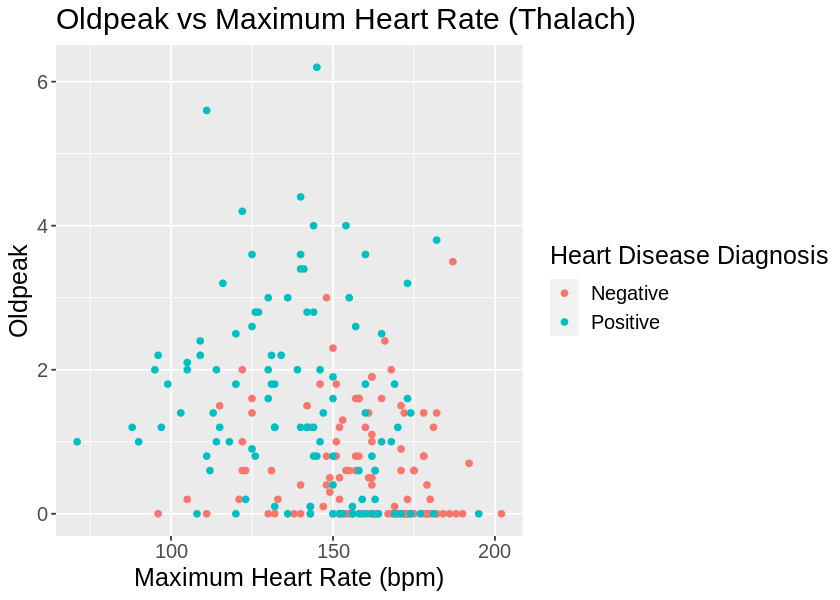

In [8]:
options(repr.plot.height = 5, repr.plot.width = 7)

age_thalach_plot <- heart_train |>
    ggplot(aes(x=age, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Maximum Heart Rate (bpm)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Maximum Heart Rate (Thalach) vs Age")
age_thalach_plot

age_chol_plot <- heart_train |>
    ggplot(aes(x=age, y=chol, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Cholesterol in serum (mg/dl)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Cholesterol Levels vs Age")
age_chol_plot

age_oldpeak_plot <- heart_train |>
    ggplot(aes(x=age, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Age")
age_oldpeak_plot

chol_thalach_plot <- heart_train |>
    ggplot(aes(x=chol, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Maximum Heart Rate (bpm)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Maximum Heart Rate (Thalach) vs Cholesterol Levels")
chol_thalach_plot

chol_oldpeak_plot <- heart_train |>
    ggplot(aes(x=chol, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Cholesterol Levels")
chol_oldpeak_plot

oldpeak_thalach_plot <- heart_train |>
    ggplot(aes(x=thalach, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Maximum Heart Rate (bpm)", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Maximum Heart Rate (Thalach)")
oldpeak_thalach_plot


We plotted the four variables against each other to narrow our number of predictors. We see that oldpeak values for many observations was zero, causing lots of overlap, so we decided not to use it.

Looking at the three graphs plotting age, serum cholesterol and thalach against each other, we decided that `age` and `thalach` are the best variables to use in our model because the graph for thalach versus age shows regions of positive and negative heart disease diagnoses which is useful for K-nearest neighbour classification. For the other two graphs, the pattern for positive and negative heart diagnoses isn't as clear and data points for positive and negative diagnoses are interspersed in one another. 

We can visualize the results of predicted diagnoses by creating a bar graph from a confusion matrix, which would compare the number of accurate predictions with inaccurate predictions. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5600220,5,0.02526279,Preprocessor1_Model01
2,accuracy,binary,0.5600220,5,0.02526279,Preprocessor1_Model02
3,accuracy,binary,0.6351076,5,0.03509645,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.6932148,5,0.05113912,Preprocessor1_Model23
24,accuracy,binary,0.6932148,5,0.05113912,Preprocessor1_Model24
25,accuracy,binary,0.7020070,5,0.04900481,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.7108959,5,0.04921566,Preprocessor1_Model19


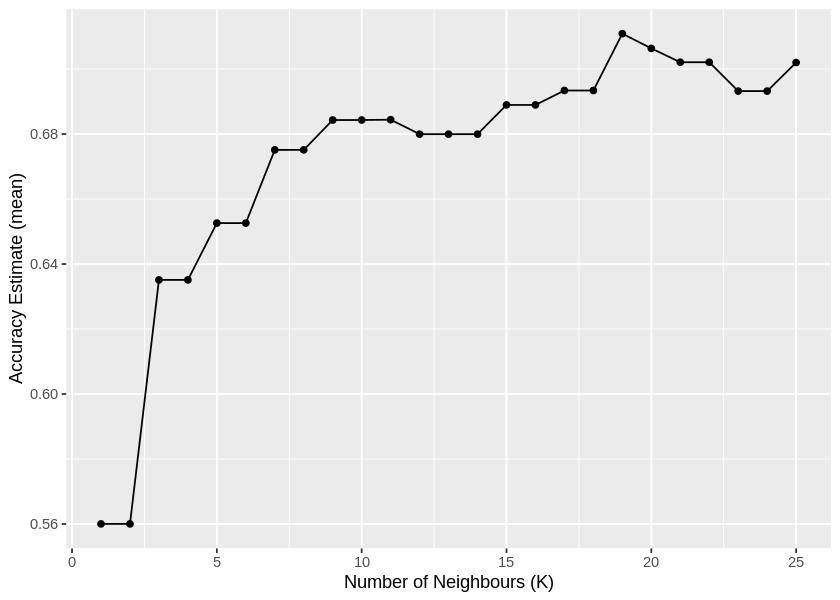

In [19]:
set.seed(293)
heart_recipe <-recipe(diagnosis ~ age + thalach, data= heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 25,by= 1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
    tune_grid(resamples= heart_vfold, grid= k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

accuracy_plot <- accuracies |>
    ggplot(aes(x= neighbors, y=mean))+
    geom_point()+
    geom_line() +
    labs(x= "Number of Neighbours (K)", y="Accuracy Estimate (mean)")
accuracy_plot

best_k <- accuracies |>
    filter( neighbors== "19")
best_k

## **References**

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved March 11, 2023, from https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1 